In [1]:
import tensorflow as tf
import numpy as np
import skimage
from PIL import Image
import matplotlib.pyplot as plt 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
slim = tf.contrib.slim

def vgg_arg_scope(weight_decay=0.0005):
  '''
  Defines the VGG arg scope.
  Args:
    weight_decay: The l2 regularization coefficient.
  Returns:
    An arg_scope.
  '''
  with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      weights_regularizer=slim.l2_regularizer(weight_decay),
                      biases_initializer=tf.zeros_initializer()):
    with slim.arg_scope([slim.conv2d], padding='SAME') as arg_sc:
        return arg_sc


def weight_initializer(stddev=0.1, he=False):
    if (he == True):
        return tf.initializers.he_normal()
    else:
        return tf.truncated_normal_initializer(mean=0, stddev=stddev)
    
    
def maxpool_with_indices(input, k_size, stride, scope):
    with tf.variable_scope(scope):
        pooled, indices = tf.nn.max_pool_with_argmax(input, k_size, stride, padding="VALID")
        return pooled, indices


def unpool(input, indices, upsample_factor, scope):
    with tf.variable_scope(scope):
        # input and indices must be of same shape
        new_size = tf.stack([input.shape[0],
                                input.shape[1]*upsample_factor,
                                input.shape[2]*upsample_factor,
                                input.shape[3]])
        batch_num = input.shape[0]
        flattened_size = input.shape[1]*upsample_factor*input.shape[2]*upsample_factor*input.shape[3]
        flat2 = input.shape[1]*input.shape[2]*input.shape[3]
        
        indices = tf.reshape(indices, [input.shape[0], -1])
        batch_indices = [tf.fill([flat2], i) for i in range(batch_num)]
        batch_indices = tf.dtypes.cast(tf.stack(batch_indices), tf.int64)
        # print(batch_indices)
        # print(indices)
        
        indices = tf.concat([tf.expand_dims(batch_indices, axis=-1), tf.expand_dims(indices, axis=-1)], axis=2)
        # print(indices)
        indices = tf.reshape(indices, [-1, 2])
        reshaped_input = tf.reshape(input, [-1])
        # print(input)
        
        scatter = tf.scatter_nd(indices, reshaped_input, tf.constant([input.shape[0], flattened_size], tf.int64))
        scatter = tf.reshape(scatter, new_size)
        # print(scatter)
        return scatter
    
def show_image(image):
    # name must be a string
    indexes = len(image.shape)
    if indexes == 3 and image.shape[2] == 1:
        height = image.shape[0]
        width = image.shape[1]
        img = np.zeros((height, width))
        for i in range(0, height):
            for j in range(0, width):
                img[i, j] = image[i, j][0] * 12
        plt.imshow(img)
    elif indexes == 4 and image.shape[3] != 1:
        height = image.shape[1]
        width = image.shape[2]
        # print(height)
        # print(width)
        img = np.zeros((height, width))
        for i in range(0, height):
            for j in range(0, width):
                img[i, j] = (np.argmax(image[0][i, j], axis=0) * 12)
        plt.imshow(img, cmap='prism')

In [3]:
def segnet(inputs,
           num_classes=1000,
           is_training=True,
           dropout_keep_prob=0.5,
           scope='segnet',
           weight_decay=0.0005):
    """Oxford Net VGG 16-Layers version D Example.
    Note: All the fully_connected layers have been transformed to conv2d layers.
          To use in classification mode, resize input to 224x224.
    Args:
      inputs: a tensor of size [batch_size, height, width, channels].
      num_classes: number of predicted classes. If 0 or None, the logits layer is
        omitted and the input features to the logits layer are returned instead.
      is_training: whether or not the model is being trained.
      dropout_keep_prob: the probability that activations are kept in the dropout
        layers during training.
      spatial_squeeze: whether or not should squeeze the spatial dimensions of the
        outputs. Useful to remove unnecessary dimensions for classification.
      scope: Optional scope for the variables.
      fc_conv_padding: the type of padding to use for the fully connected layer
        that is implemented as a convolutional layer. Use 'SAME' padding if you
        are applying the network in a fully convolutional manner and want to
        get a prediction map downsampled by a factor of 32 as an output.
        Otherwise, the output prediction map will be (input / 32) - 6 in case of
        'VALID' padding.
      global_pool: Optional boolean flag. If True, the input to the classification
        layer is avgpooled to size 1x1, for any input size. (This is not part
        of the original VGG architecture.)
    Returns:
      net: the output of the logits layer (if num_classes is a non-zero integer),
        or the input to the logits layer (if num_classes is 0 or None).
      end_points: a dict of tensors with intermediate activations.
    """
    with tf.variable_scope('segnet', reuse=tf.AUTO_REUSE):
        # Collect outputs for conv2d, fully_connected and max_pool2d.
        net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
        print(f"size after conv1 is = {net.shape}")
        net, indices1 = maxpool_with_indices(net, k_size=[1, 2, 2, 1], stride=[
                                             1, 2, 2, 1], scope='pool1')
        print(f"size after pool1 is = {net.shape}")
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
        print(f"size after conv2 is = {net.shape}")
        net, indices2 = maxpool_with_indices(net, k_size=[1, 2, 2, 1], stride=[
                                             1, 2, 2, 1], scope='pool2')
        print(f"size after pool2 is = {net.shape}")
        net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
        print(f"size after conv3 is = {net.shape}")
        net, indices3 = maxpool_with_indices(net, k_size=[1, 2, 2, 1], stride=[
                                             1, 2, 2, 1], scope='pool3')
        print(f"size after pool3 is = {net.shape}")
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
        print(f"size after conv4 is = {net.shape}")
        net, indices4 = maxpool_with_indices(net, k_size=[1, 2, 2, 1], stride=[
                                             1, 2, 2, 1], scope='pool4')
        print(f"size after pool4 is = {net.shape}")
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
        print(f"size after conv5 is = {net.shape}")
        net, indices5 = maxpool_with_indices(net, k_size=[1, 2, 2, 1], stride=[
                                             1, 2, 2, 1], scope='pool5')
        print(f"size after pool5 is = {net.shape}")
        
        mid_output = net

        net = unpool(net, indices5, upsample_factor=2, scope='unpool5')
        print(f"size after unpool5 is = {net.shape}")
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], weights_regularizer=slim.l2_regularizer(
            weight_decay), scope='decoder_conv5')
        print(f"size after decoder_conv5 is = {net.shape}")
        net = unpool(net, indices4, upsample_factor=2, scope='unpool4')
        print(f"size after unpool4 is = {net.shape}")
        net = slim.repeat(net, 2, slim.conv2d, 512, [3, 3], weights_regularizer=slim.l2_regularizer(
            weight_decay), scope='decoder_conv4')
        net = slim.conv2d(net, 256, 3, scope='decoder_conv4/decoder_conv4_3')
        print(f"size after decoder_conv4 is = {net.shape}")
        net = unpool(net, indices3, upsample_factor=2, scope='unpool3')
        print(f"size after unpool3 is = {net.shape}")
        net = slim.repeat(net, 2, slim.conv2d, 256, [3, 3], weights_regularizer=slim.l2_regularizer(
            weight_decay), scope='decoder_conv3')
        net = slim.conv2d(net, 128, 3, scope='decoder_conv3/decoder_conv3_3')
        print(f"size after decoder_conv3 is = {net.shape}")
        net = unpool(net, indices2, upsample_factor=2, scope='unpool2')
        print(f"size after unpool2 is = {net.shape}")
        net = slim.conv2d(net, 128, 3, scope='decoder_conv2/decoder_conv2_1')
        net = slim.conv2d(net, 64, 3, scope='decoder_conv2/decoder_conv2_2')
        print(f"size after decoder_conv2 is = {net.shape}")
        net = unpool(net, indices1, upsample_factor=2, scope='unpool1')
        print(f"size after unpool1 is = {net.shape}")
        net = slim.conv2d(net, 64, 3, scope='decoder_conv1/decoder_conv1_1')
        print(f"size after decoder_conv1 is = {net.shape}")
        net = slim.conv2d(net, num_classes, 3,
                          activation_fn=None,
                          weights_regularizer=slim.l2_regularizer(weight_decay),
                          biases_initializer=tf.zeros_initializer(),
                          scope='decoder_conv1/decoder_conv1_2')
        print(f"final size after is = {net.shape}")

        return mid_output, net

In [4]:
batch_size = 1
X_train = tf.placeholder(tf.float32, (batch_size, 224, 224, 3))

mid, logits = segnet(X_train)

img_mask = tf.nn.softmax(logits, axis=3)

size after conv1 is = (1, 224, 224, 64)
size after pool1 is = (1, 112, 112, 64)
size after conv2 is = (1, 112, 112, 128)
size after pool2 is = (1, 56, 56, 128)
size after conv3 is = (1, 56, 56, 256)
size after pool3 is = (1, 28, 28, 256)
size after conv4 is = (1, 28, 28, 512)
size after pool4 is = (1, 14, 14, 512)
size after conv5 is = (1, 14, 14, 512)
size after pool5 is = (1, 7, 7, 512)
size after unpool5 is = (1, 14, 14, 512)
size after decoder_conv5 is = (1, 14, 14, 512)
size after unpool4 is = (1, 28, 28, 512)
size after decoder_conv4 is = (1, 28, 28, 256)
size after unpool3 is = (1, 56, 56, 256)
size after decoder_conv3 is = (1, 56, 56, 128)
size after unpool2 is = (1, 112, 112, 128)
size after decoder_conv2 is = (1, 112, 112, 64)
size after unpool1 is = (1, 224, 224, 64)
size after decoder_conv1 is = (1, 224, 224, 64)
final size after is = (1, 224, 224, 1000)


In [5]:
print(mid)
print(logits)
print(img_mask)
print(tf.trainable_variables())

Tensor("segnet/pool5/MaxPoolWithArgmax:0", shape=(1, 7, 7, 512), dtype=float32)
Tensor("segnet/decoder_conv1/decoder_conv1_2/BiasAdd:0", shape=(1, 224, 224, 1000), dtype=float32)
Tensor("Softmax:0", shape=(1, 224, 224, 1000), dtype=float32)
[<tf.Variable 'segnet/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>, <tf.Variable 'segnet/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'segnet/conv1/conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'segnet/conv1/conv1_2/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'segnet/conv2/conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'segnet/conv2/conv2_1/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'segnet/conv2/conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>, <tf.Variable 'segnet/conv2/conv2_2/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'segnet/conv3/conv3_1/weights:0' shape=(3, 3, 128, 256) dtype=float32_ref>, <tf.Varia

In [6]:
with tf.variable_scope('segnet', reuse=tf.AUTO_REUSE):
    b1 = tf.get_variable("conv1/conv1_1/biases")
    W1 = tf.get_variable("conv1/conv1_1/weights")
    b2 = tf.get_variable("conv1/conv1_2/biases")
    W2 = tf.get_variable("conv1/conv1_2/weights")
    b3 = tf.get_variable("conv2/conv2_1/biases")
    W3 = tf.get_variable("conv2/conv2_1/weights")
    b4 = tf.get_variable("conv2/conv2_2/biases")
    W4 = tf.get_variable("conv2/conv2_2/weights")
    b5 = tf.get_variable("conv3/conv3_1/biases")
    W5 = tf.get_variable("conv3/conv3_1/weights")
    b6 = tf.get_variable("conv3/conv3_2/biases")
    W6 = tf.get_variable("conv3/conv3_2/weights")
    b7 = tf.get_variable("conv3/conv3_3/biases")
    W7 = tf.get_variable("conv3/conv3_3/weights")
    b8 = tf.get_variable("conv4/conv4_1/biases")
    W8 = tf.get_variable("conv4/conv4_1/weights")
    b9 = tf.get_variable("conv4/conv4_2/biases")
    W9 = tf.get_variable("conv4/conv4_2/weights")
    b10 = tf.get_variable("conv4/conv4_3/biases")
    W10 = tf.get_variable("conv4/conv4_3/weights")
    b11 = tf.get_variable("conv5/conv5_1/biases")
    W11 = tf.get_variable("conv5/conv5_1/weights")
    b12 = tf.get_variable("conv5/conv5_2/biases")
    W12 = tf.get_variable("conv5/conv5_2/weights")
    b13 = tf.get_variable("conv5/conv5_3/biases")
    W13 = tf.get_variable("conv5/conv5_3/weights")

(171, 240, 3)
(224, 224, 3)


C:\Users\shash\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\shash\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


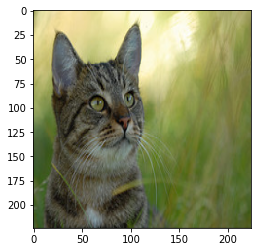

In [7]:
img = Image.open("cat.jpg")
img1 = np.array(img)
print(img1.shape)
img2 = skimage.transform.resize(img1, output_shape=(224,224,3))
print(img2.shape)
plt.imshow(img2)

mean = [123.68, 116.78, 103.94]
img2 = img2 - mean

In [8]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter('./log/summary/', sess.graph)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver({"vgg_16/conv1/conv1_1/biases": b1,
                           "vgg_16/conv1/conv1_1/weights": W1,
                           "vgg_16/conv1/conv1_2/biases": b2,
                           "vgg_16/conv1/conv1_2/weights": W2,
                           "vgg_16/conv2/conv2_1/biases": b3,
                           "vgg_16/conv2/conv2_1/weights": W3,
                           "vgg_16/conv2/conv2_2/biases": b4,
                           "vgg_16/conv2/conv2_2/weights": W4,
                           "vgg_16/conv3/conv3_1/biases": b5,
                           "vgg_16/conv3/conv3_1/weights": W5,
                           "vgg_16/conv3/conv3_2/biases": b6,
                           "vgg_16/conv3/conv3_2/weights": W6,
                           "vgg_16/conv3/conv3_3/biases": b7,
                           "vgg_16/conv3/conv3_3/weights": W7,
                           "vgg_16/conv4/conv4_1/biases": b8,
                           "vgg_16/conv4/conv4_1/weights": W8,
                           "vgg_16/conv4/conv4_2/biases": b9,
                           "vgg_16/conv4/conv4_2/weights": W9,
                           "vgg_16/conv4/conv4_3/biases": b10,
                           "vgg_16/conv4/conv4_3/weights": W10,
                           "vgg_16/conv5/conv5_1/biases": b11,
                           "vgg_16/conv5/conv5_1/weights": W11,
                           "vgg_16/conv5/conv5_2/biases": b12,
                           "vgg_16/conv5/conv5_2/weights": W12,
                           "vgg_16/conv5/conv5_3/biases": b13,
                           "vgg_16/conv5/conv5_3/weights": W13})
    saver.restore(sess, "./vgg/vgg_16.ckpt")
    
    middle_output, logit, img = sess.run([mid, logits, img_mask], feed_dict={X_train: np.expand_dims(img2, axis=0)})
    variable_W2 = sess.run(W2)
    weight_W2 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "segnet/conv1/conv1_2/weights")[0]
    weight_W2_value = sess.run(weight_W2)
    writer.close()

INFO:tensorflow:Restoring parameters from ./vgg/vgg_16.ckpt


In [9]:
print(logit.shape)
print(img.shape)
print(middle_output.shape)
print(variable_W2.shape)
print(weight_W2_value.shape)

(1, 224, 224, 1000)
(1, 224, 224, 1000)
(1, 7, 7, 512)
(3, 3, 64, 64)
(3, 3, 64, 64)


992
[[ 5.158424  16.264725   9.471423   9.112394   9.250825   9.439708
  18.648382 ]
 [ 4.771631  14.575315   9.527058   9.393553   9.297786   9.8317585
  19.861904 ]
 [ 4.3873405 12.188002   7.8187666  7.5414696  7.713867   8.4812
  14.858767 ]
 [ 4.0674696 11.83914    7.561396   7.2504253  7.38362    7.7539124
  14.356684 ]
 [ 4.0390363 11.91588    7.8418117  7.6624675  7.678916   7.9270163
  14.338961 ]
 [ 4.976983  14.934841   9.170095   8.962254   9.065472   9.350262
  18.604216 ]
 [ 0.         0.         0.         0.         0.         0.
   1.4934735]]
441


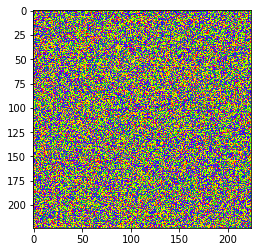

In [10]:
class_idx = np.argmax(img[0][6, 2, :])
print(class_idx)
segmentation_mask = show_image(img)
class_111_idx = np.argmax(middle_output[0][4,2,:])
class_111_mask = middle_output[0][:,:,441]
print(class_111_mask)
print(class_111_idx)

[[ 5.158424  16.264725   9.471423   9.112394   9.250825   9.439708
  18.648382 ]
 [ 4.771631  14.575315   9.527058   9.393553   9.297786   9.8317585
  19.861904 ]
 [ 4.3873405 12.188002   7.8187666  7.5414696  7.713867   8.4812
  14.858767 ]
 [ 4.0674696 11.83914    7.561396   7.2504253  7.38362    7.7539124
  14.356684 ]
 [ 4.0390363 11.91588    7.8418117  7.6624675  7.678916   7.9270163
  14.338961 ]
 [ 4.976983  14.934841   9.170095   8.962254   9.065472   9.350262
  18.604216 ]
 [ 0.         0.         0.         0.         0.         0.
   1.4934735]]


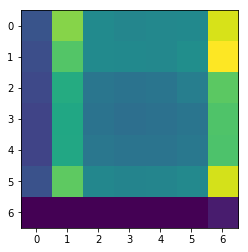

In [11]:
print(class_111_mask)
plt.imshow(class_111_mask)

In [12]:
print(variable_W2)

[[[[ 1.66219279e-01  1.42701820e-01 -4.02113283e-03 ...  6.18828237e-02
    -1.74057148e-02 -3.00644431e-02]
   [ 9.46945231e-03  3.87477316e-03  5.08365929e-02 ... -2.77981739e-02
     1.71373668e-03  6.82722731e-03]
   [ 6.32681847e-02  2.12877709e-02 -1.63465310e-02 ...  8.80054955e-04
     6.68104272e-03 -1.41139806e-03]
   ...
   [ 3.47490981e-03  8.47019628e-02 -4.07223180e-02 ... -1.13523193e-02
    -7.48998486e-03  3.19077494e-03]
   [ 5.97234145e-02  4.97663505e-02 -3.23118735e-03 ...  1.43114366e-02
     3.03175431e-02 -4.23925705e-02]
   [ 1.33459672e-01  4.95484173e-02 -1.78808011e-02 ...  2.25385167e-02
     3.02020740e-02 -2.17075031e-02]]

  [[ 2.12007999e-01  2.10127644e-02 -1.47626130e-02 ...  2.29580477e-02
     1.23102348e-02 -3.08422819e-02]
   [-2.62175221e-03  7.42094172e-03  6.74030930e-02 ... -3.06594316e-02
     1.80578313e-03  4.27369215e-03]
   [ 2.27197763e-02 -1.07841045e-02 -1.31095545e-02 ... -1.15751950e-02
     4.18359675e-02 -1.92268589e-03]
   ...
   

In [13]:
print(weight_W2_value)

[[[[ 1.66219279e-01  1.42701820e-01 -4.02113283e-03 ...  6.18828237e-02
    -1.74057148e-02 -3.00644431e-02]
   [ 9.46945231e-03  3.87477316e-03  5.08365929e-02 ... -2.77981739e-02
     1.71373668e-03  6.82722731e-03]
   [ 6.32681847e-02  2.12877709e-02 -1.63465310e-02 ...  8.80054955e-04
     6.68104272e-03 -1.41139806e-03]
   ...
   [ 3.47490981e-03  8.47019628e-02 -4.07223180e-02 ... -1.13523193e-02
    -7.48998486e-03  3.19077494e-03]
   [ 5.97234145e-02  4.97663505e-02 -3.23118735e-03 ...  1.43114366e-02
     3.03175431e-02 -4.23925705e-02]
   [ 1.33459672e-01  4.95484173e-02 -1.78808011e-02 ...  2.25385167e-02
     3.02020740e-02 -2.17075031e-02]]

  [[ 2.12007999e-01  2.10127644e-02 -1.47626130e-02 ...  2.29580477e-02
     1.23102348e-02 -3.08422819e-02]
   [-2.62175221e-03  7.42094172e-03  6.74030930e-02 ... -3.06594316e-02
     1.80578313e-03  4.27369215e-03]
   [ 2.27197763e-02 -1.07841045e-02 -1.31095545e-02 ... -1.15751950e-02
     4.18359675e-02 -1.92268589e-03]
   ...
   